In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
import pandas as pd
import numpy as np

In [3]:
df= pd.read_csv('Fraud.csv')

In [4]:
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)

fraud_proportions = df['isFraud'].value_counts(normalize=True)
print(fraud_proportions)

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Reducing size for faster computation

In [6]:
fraudulent_rows = df[df['isFraud'] == 1]
non_fraudulent_rows = df[df['isFraud'] == 0]

sampled_non_fraudulent = non_fraudulent_rows.sample(n=100000, random_state=42)

sampled_df = pd.concat([fraudulent_rows, sampled_non_fraudulent])

sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(sampled_df['isFraud'].value_counts())


isFraud
0    100000
1      8213
Name: count, dtype: int64


In [7]:
df= sampled_df

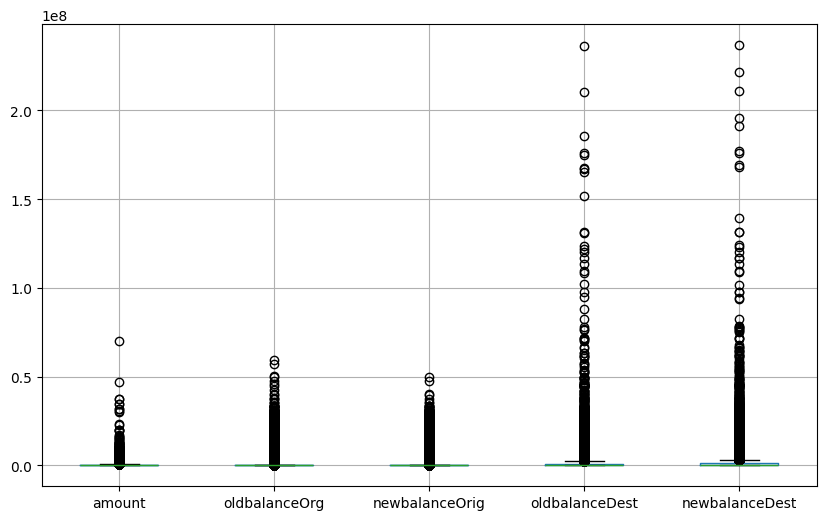

In [15]:
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].boxplot(figsize=(10, 6))
plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108213 entries, 0 to 108212
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            108213 non-null  int64  
 1   type            108213 non-null  object 
 2   amount          108213 non-null  float64
 3   nameOrig        108213 non-null  object 
 4   oldbalanceOrg   108213 non-null  float64
 5   newbalanceOrig  108213 non-null  float64
 6   nameDest        108213 non-null  object 
 7   oldbalanceDest  108213 non-null  float64
 8   newbalanceDest  108213 non-null  float64
 9   isFraud         108213 non-null  int64  
 10  isFlaggedFraud  108213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.1+ MB


In [17]:
df.describe

<bound method NDFrame.describe of         step      type      amount     nameOrig  oldbalanceOrg  \
0        284   PAYMENT     2295.98  C1799658065           0.00   
1        133   CASH_IN   120287.94   C749056708     1666154.29   
2        692  TRANSFER   471086.30  C1237394124           0.00   
3        298  CASH_OUT   123429.86   C264963194           0.00   
4        134  CASH_OUT   120410.65  C1654380606           0.00   
...      ...       ...         ...          ...            ...   
108208   331   CASH_IN    52454.74   C945681277       15651.00   
108209   384   PAYMENT    10770.95  C1867116174      457392.22   
108210   181  CASH_OUT   129035.89  C1034098653       12546.00   
108211    71  TRANSFER  1871553.73   C677678546     1871553.73   
108212   335   CASH_IN    98932.38  C2033626434     1609496.52   

        newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0                 0.00  M1888808576            0.00            0.00        0   
1           1

In [18]:
df.shape

(108213, 11)

In [19]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,284,PAYMENT,2295.98,C1799658065,0.00,0.00,M1888808576,0.00,0.00,0,0
1,133,CASH_IN,120287.94,C749056708,1666154.29,1786442.23,C1338686176,4554705.75,4434417.81,0,0
2,692,TRANSFER,471086.30,C1237394124,0.00,0.00,C710564759,611927.51,1083013.81,0,0
3,298,CASH_OUT,123429.86,C264963194,0.00,0.00,C1811291679,706827.07,830256.93,0,0
4,134,CASH_OUT,120410.65,C1654380606,0.00,0.00,C623388952,3280374.44,3400785.09,0,0


In [20]:
df.value_counts()

step  type      amount      nameOrig     oldbalanceOrg  newbalanceOrig  nameDest     oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
1     CASH_IN   7322.98     C913242382   6681389.66     6688712.64      C146305349   64966.00        57643.02        0        0                 1
310   TRANSFER  1322881.95  C787587917   0.00           0.00            C869703765   3987000.11      5309882.05      0        0                 1
311   CASH_IN   163830.07   C1590327812  116468.00      280298.07       C631545959   5124269.89      4960439.82      0        0                 1
                152620.12   C779756195   988378.62      1140998.74      C1699968502  167565.56       14945.43        0        0                 1
                150291.82   C1354311277  22983668.54    23133960.36     C24161874    717146.29       566854.47       0        0                 1
                                                                                                                                 

Adding more columns, in order to gain better insights

Merchant transactions hold a special value as mentioned

In [21]:
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

df['destTransactionCount'] = df.groupby('nameDest')['nameDest'].transform('count')
df['origTransactionCount'] = df.groupby('nameOrig')['nameOrig'].transform('count')

df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

To check that at what time is rate more of frauds

In [22]:
df['day'] = df['step'] // 24
df['hour'] = df['step'] % 24
fraud_by_day = df[df['isFraud'] == 1]['day'].value_counts()
fraud_by_hour = df[df['isFraud'] == 1]['hour'].value_counts()

In [23]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

balance change

In [24]:
df['balanceChangeOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']

Did the amount get completely drained after transaction

In [25]:
df['isDrainOrig'] = (df['newbalanceOrig'] == 0).astype(int)

Higher amount transactions are suspicious

In [26]:
df['isSuspicious'] = ((df['amount'] > 200000) | (df['newbalanceOrig'] == 0)).astype(int)

In [27]:
df['origTransactionVelocity'] = df['origTransactionCount'] / (df['day'] + 1)
df['destTransactionVelocity'] = df['destTransactionCount'] / (df['day'] + 1)

In [28]:
df.drop(['step'], axis=1, inplace=True)

In [29]:
print(df['isFraud'].value_counts())
print(df['isFlaggedFraud'].value_counts())

isFraud
0    100000
1      8213
Name: count, dtype: int64
isFlaggedFraud
0    108197
1        16
Name: count, dtype: int64


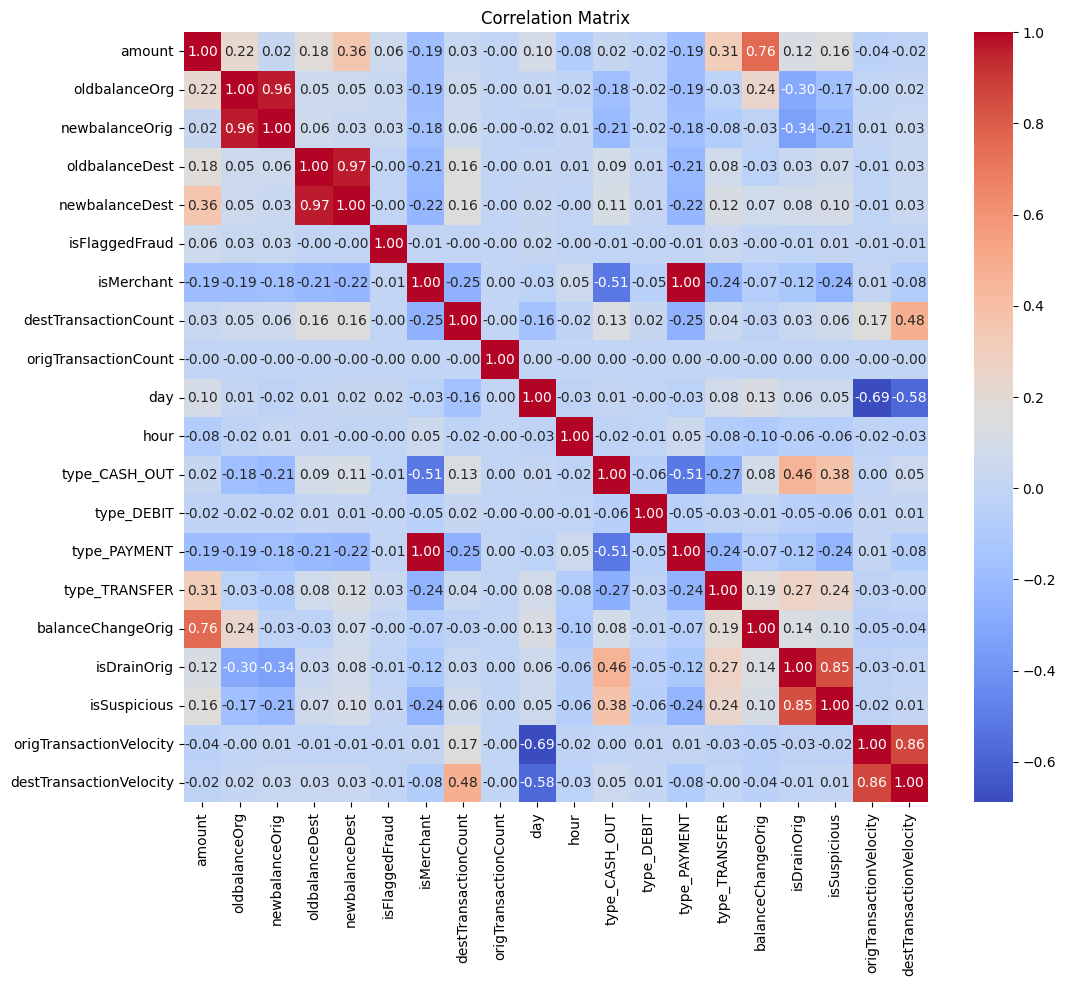

Number of highly correlated features (correlation > 0.9): 26


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
target = 'isFraud'
features = [col for col in df.columns if col != target]
corr = df[features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Look for pairs of features with correlation > 0.9 (for example)
correlated_features = (corr > 0.9).sum().sum()  # Count highly correlated pairs
print(f"Number of highly correlated features (correlation > 0.9): {correlated_features}")

Correlation among our improved dataframe is balanced

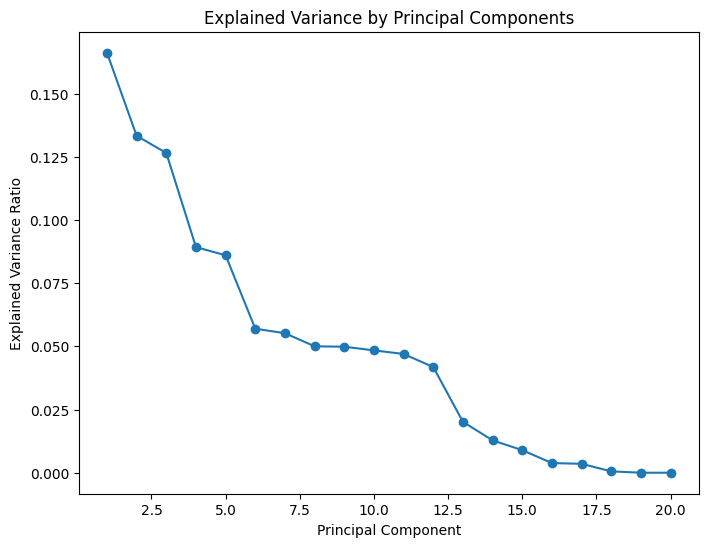

In [33]:
from sklearn.decomposition import PCA

# Standardize the data (important for PCA)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If the first few components explain most of the variance, it indicates low multicollinearity.


In [34]:
target = 'isFraud'
features = [col for col in df.columns if col != target]

X = df.drop(columns=['isFraud']) 
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Dataset is unbalanced, using SMOTE to increase rows of 'target' by generating nearest neighbours

In [35]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

smote = SMOTE(sampling_strategy=0.1,random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

c:\Users\hardi\OneDrive\Desktop\accredian\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\hardi\OneDrive\Desktop\accredian\.venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [36]:
corr = df.corr()
print(corr['isFraud'].sort_values(ascending=False))

isFraud                    1.000000
balanceChangeOrig          0.506182
amount                     0.353158
type_TRANSFER              0.343889
isDrainOrig                0.222342
day                        0.221976
isSuspicious               0.198208
type_CASH_OUT              0.082853
oldbalanceOrg              0.076248
isFlaggedFraud             0.042433
newbalanceDest             0.003706
origTransactionCount      -0.001232
type_DEBIT                -0.022209
destTransactionCount      -0.030011
oldbalanceDest            -0.042632
destTransactionVelocity   -0.057541
newbalanceOrig            -0.060712
origTransactionVelocity   -0.071108
isMerchant                -0.194302
type_PAYMENT              -0.194302
hour                      -0.214416
Name: isFraud, dtype: float64


In [37]:
target = 'isFraud'
features = [col for col in df.columns if col != target]

X = df.drop(columns=['isFraud']) 
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Testing on decision tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
dt_model = DecisionTreeClassifier(
    criterion='gini',               # Gini impurity (can also use 'entropy')
    max_depth=10,                   # Maximum depth of the tree
    min_samples_split=10,           # Minimum samples required to split an internal node
    min_samples_leaf=5,             # Minimum samples required to be at a leaf node
    max_features='sqrt',            # Number of features to consider when looking for the best split
    random_state=42                 # Ensure reproducibility
)

In [44]:
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluate using ROC-AUC score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("Feature Importances:")
print(dt_model.feature_importances_)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30000
           1       0.94      0.88      0.91      2464

    accuracy                           0.99     32464
   macro avg       0.97      0.94      0.95     32464
weighted avg       0.99      0.99      0.99     32464

ROC-AUC Score: 0.9402534632034633
Feature Importances:
[4.98175646e-02 1.38329536e-01 1.52009428e-04 4.05681239e-02
 3.24113069e-02 0.00000000e+00 3.71066896e-03 1.37553610e-03
 0.00000000e+00 4.86527327e-03 5.01744092e-02 5.11024804e-03
 0.00000000e+00 6.65164597e-04 1.67734201e-02 5.84320095e-02
 4.10165500e-01 8.54765321e-04 1.65925308e-01 2.06691560e-02]


testing on random forest

In [38]:
model = RandomForestClassifier(
    n_estimators=100,           
    max_depth=15,               
    min_samples_split=10,       
    min_samples_leaf=5,         
    n_jobs=-1,                  
    random_state=42
)

In [39]:
model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=10,
                       n_jobs=-1, random_state=42)

In [40]:
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30000
           1       0.97      0.95      0.96      2464

    accuracy                           0.99     32464
   macro avg       0.98      0.97      0.98     32464
weighted avg       0.99      0.99      0.99     32464

ROC-AUC Score: 0.9729593073593075


In [45]:
print("Feature Importances:")
print(model.feature_importances_)

Feature Importances:
[1.10048898e-01 9.48742300e-02 2.70365672e-02 4.48794980e-02
 8.26990050e-02 1.39249072e-04 7.92892467e-03 7.75584165e-04
 0.00000000e+00 4.12954534e-02 7.73072241e-02 1.30236495e-02
 4.32244855e-05 1.22322958e-02 4.86614116e-02 3.48507688e-01
 3.44170745e-02 1.14114832e-02 2.45664624e-02 2.01520762e-02]


Random forest was a better model than decision tree